In [62]:
# --- Minimal loader for Telco datasets ---
from pathlib import Path
import pandas as pd

# 1) Point to repo root
# Where this notebook lives
NOTEBOOK_DIR = Path.cwd()

# Path to raw data (same logic as processed loader)
DATA_RAW = (NOTEBOOK_DIR / "../data/raw").resolve()

print("DATA_RAW:", DATA_RAW)

# 2) Files to load
files = {
    "demographics": "Telco_customer_churn_demographics.csv",
    "location":     "Telco_customer_churn_location.csv",
    "population":   "Telco_customer_churn_population.csv",
    "services":     "Telco_customer_churn_services.csv",
    "status":       "Telco_customer_churn_status.csv",
}

# 3) Load CSVs (auto-detect separator)
dfs = {}
for name, fname in files.items():
    path = DATA_RAW / fname
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")

    dfs[name] = pd.read_csv(
        path,
        sep=None,
        engine="python",
        encoding="utf-8-sig"
    )

# 4) Sanity check
for name, df in dfs.items():
    print(f"\n{name}: {df.shape}")
    print(df.columns.tolist())

# 5) Assign to variables
demographics = dfs["demographics"]
location     = dfs["location"]
population   = dfs["population"]
services     = dfs["services"]
status       = dfs["status"]

DATA_RAW: /Users/pedro.cabeco/Project_EDSB-1/data/raw

demographics: (7043, 9)
['Customer ID', 'Count', 'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Number of Dependents']

location: (7043, 9)
['Customer ID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude']

population: (1671, 3)
['ID', 'Zip Code', 'Population']

services: (7043, 30)
['Customer ID', 'Count', 'Quarter', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Avg Monthly GB Download', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']

status: (7043, 

In [63]:
# Helper to standardize column names
def standardize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
        .str.replace("/", "_")
    )
    return df


In [64]:
# Start from the raw location df in dfs
location = dfs["location"].copy()

# 1) Standardize column names
location = standardize_columns(location)
print("Location columns after standardize:", location.columns.tolist())

# 2) Drop unneeded columns IF they exist
cols_to_drop = [c for c in ["count", "lat_long", "country"] if c in location.columns]
location = location.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)

# 3) Convert zip_code to 5-char string
if "zip_code" in location.columns:
    location["zip_code"] = (
        location["zip_code"]
        .astype(str)
        .str.zfill(5)
    )

location.head()

Location columns after standardize: ['customer_id', 'count', 'country', 'state', 'city', 'zip_code', 'lat_long', 'latitude', 'longitude']
Dropped columns: ['count', 'lat_long', 'country']


,customer_id,state,city,zip_code,latitude,longitude
0,8779-QRDMV,California,Los Angeles,90022,34.023810,-118.156582
1,7495-OOKFY,California,Los Angeles,90063,34.044271,-118.185237
2,1658-BYGOY,California,Los Angeles,90065,34.108833,-118.229715
3,4598-XLKNJ,California,Inglewood,90303,33.936291,-118.332639
4,4846-WHAFZ,California,Whittier,90602,33.972119,-118.020188


In [65]:
# 2.2.2 Population table pre-merge cleaning

# 1) Inspect current structure (optional sanity check)
print(population.head())
print(population.info())

# 2) Drop unneeded technical ID column
if "ID" in population.columns:
    population = population.drop(columns=["ID"])

# 3) Ensure Zip Code is a 5-char string aligned with `location`
if "Zip Code" in population.columns:
    population["Zip Code"] = (
        population["Zip Code"]
        .astype(str)
        .str.zfill(5)
    )

# 4) Standardise column names
population = population.rename(
    columns={
        "Zip Code": "zip_code",
        "Population": "population"
    }
)

# 5) Quick check after cleaning
print(population.head())
print(population.describe(include="all"))

   ID  Zip Code  Population
0   1     90001       54492
1   2     90002       44586
2   3     90003       58198
3   4     90004       67852
4   5     90005       43019
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          1671 non-null   int64
 1   Zip Code    1671 non-null   int64
 2   Population  1671 non-null   int64
dtypes: int64(3)
memory usage: 39.3 KB
None
  zip_code  population
0    90001       54492
1    90002       44586
2    90003       58198
3    90004       67852
4    90005       43019
       zip_code     population
count      1671    1671.000000
unique     1671            NaN
top       90001            NaN
freq          1            NaN
mean        NaN   20276.384201
std         NaN   20689.117300
min         NaN      11.000000
25%         NaN    1789.000000
50%         NaN   14239.000000
75%         NaN   32942.500000
max     

In [66]:
# 2.3 Services table pre-merge cleaning

# Start from raw services df
services = dfs["services"].copy()

# 1) Standardize column names
services = standardize_columns(services)
print("Services columns after standardize:", services.columns.tolist())

# 2) Drop unneeded columns
# - 'count' is just a counter
# - 'quarter' we will keep from status table instead
cols_to_drop = [c for c in ["count", "quarter"] if c in services.columns]
services = services.drop(columns=cols_to_drop)
print("Dropped columns from services:", cols_to_drop)

# 3) Ensure customer_id is string
if "customer_id" in services.columns:
    services["customer_id"] = services["customer_id"].astype(str)

# 4) Make sure numeric columns are really numeric
num_cols = [
    "number_of_referrals",
    "tenure_in_months",
    "avg_monthly_long_distance_charges",
    "avg_monthly_gb_download",
    "monthly_charge",
    "total_charges",
    "total_refunds",
    "total_extra_data_charges",
    "total_long_distance_charges",
]

for col in num_cols:
    if col in services.columns:
        services[col] = pd.to_numeric(services[col], errors="coerce")

# 5) Quick check
print("\nMissing values in key columns:")
cols_to_check = ["offer", "internet_type"] + num_cols
cols_to_check = [c for c in cols_to_check if c in services.columns]
print(services[cols_to_check].isna().sum())

services.head()


Services columns after standardize: ['customer_id', 'count', 'quarter', 'referred_a_friend', 'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service', 'avg_monthly_long_distance_charges', 'multiple_lines', 'internet_service', 'internet_type', 'avg_monthly_gb_download', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue']
Dropped columns from services: ['count', 'quarter']

Missing values in key columns:
offer                                3877
internet_type                        1526
number_of_referrals                     0
tenure_in_months                        0
avg_monthly_long_distance_charges       0
avg_monthly_gb_download                 0
monthly_charge                          0
tot

,customer_id,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,...,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,8779-QRDMV,No,0,1,NaN,No,0.00,No,Yes,DSL,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


In [67]:
# 2.4 Status table pre-merge cleaning

# Start from raw status df
status = dfs["status"].copy()

# 1) Standardize column names
status = standardize_columns(status)
print("Status columns after standardize:", status.columns.tolist())

# 2) Drop unneeded columns (only 'count' in this table)
cols_to_drop = [c for c in ["count"] if c in status.columns]
status = status.drop(columns=cols_to_drop)
print("Dropped columns from status:", cols_to_drop)

# 3) Ensure customer_id is string
if "customer_id" in status.columns:
    status["customer_id"] = status["customer_id"].astype(str)

# 4) Make sure numeric fields are numeric (using snake_case names)
num_cols = ["churn_score", "cltv", "churn_value", "satisfaction_score"]
for col in num_cols:
    if col in status.columns:
        status[col] = pd.to_numeric(status[col], errors="coerce")

# 5) Quick sanity check
print("\nDtypes after cleaning:")
print(status.dtypes)

print("\nMissing values per column:")
print(status.isna().sum())

status.head()

Status columns after standardize: ['customer_id', 'count', 'quarter', 'satisfaction_score', 'customer_status', 'churn_label', 'churn_value', 'churn_score', 'cltv', 'churn_category', 'churn_reason']
Dropped columns from status: ['count']

Dtypes after cleaning:
customer_id           object
quarter               object
satisfaction_score     int64
customer_status       object
churn_label           object
churn_value            int64
churn_score            int64
cltv                   int64
churn_category        object
churn_reason          object
dtype: object

Missing values per column:
customer_id              0
quarter                  0
satisfaction_score       0
customer_status          0
churn_label              0
churn_value              0
churn_score              0
cltv                     0
churn_category        5174
churn_reason          5174
dtype: int64


,customer_id,quarter,satisfaction_score,customer_status,churn_label,churn_value,churn_score,cltv,churn_category,churn_reason
0,8779-QRDMV,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [68]:
# Ensure consistent column names before merging
demographics = standardize_columns(demographics)
location      = standardize_columns(location)
services      = standardize_columns(services)
status        = standardize_columns(status)

# sanity check (optional)
for name, df_ in [
    ("demographics", demographics),
    ("location",    location),
    ("services",    services),
    ("status",      status),
]:
    print(name, "-> has customer_id?", "customer_id" in df_.columns)

demographics -> has customer_id? True
location -> has customer_id? True
services -> has customer_id? True
status -> has customer_id? True


In [69]:
from pathlib import Path
import pandas as pd

# Where this notebook lives
NOTEBOOK_DIR = Path.cwd()

# Paths
DATA_RAW = (NOTEBOOK_DIR / "../data/raw").resolve()
DATA_PROCESSED = (NOTEBOOK_DIR / "../data/processed").resolve()

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# -------------------------------
# 1) Sanity check: unique customer_id
# -------------------------------
for name, df_ in [
    ("demographics", demographics),
    ("location",     location),
    ("services",     services),
    ("status",       status),
]:
    print(
        f"{name:12s} -> rows: {len(df_):5d} | "
        f"unique customer_id: {df_['customer_id'].nunique():5d}"
    )

# -------------------------------
# 2) Merge core tables (1–1 joins)
# -------------------------------
merged = (
    demographics
        .merge(location, on="customer_id", how="left", validate="one_to_one")
        .merge(services, on="customer_id", how="left", validate="one_to_one")
        .merge(status,   on="customer_id", how="left", validate="one_to_one")
)

print("\nShape after core merges:", merged.shape)

# -------------------------------
# 3) Merge population (many–to–one via zip_code)
# -------------------------------
if "zip_code" in merged.columns and "zip_code" in population.columns:
    merged["zip_code"] = merged["zip_code"].astype(str).str.zfill(5)
    population["zip_code"] = population["zip_code"].astype(str).str.zfill(5)

    merged = merged.merge(
        population,
        on="zip_code",
        how="left",
        validate="many_to_one"
    )
    print("Shape after adding population:", merged.shape)
else:
    print("⚠️ zip_code missing — population not merged")

# -------------------------------
# 4) Final integrity checks
# -------------------------------
print("\nFinal column count:", len(merged.columns))
print("Any duplicated customer_id?",
      merged["customer_id"].duplicated().any())

print("\nTop missing values:")
display(
    merged.isna()
          .sum()
          .sort_values(ascending=False)
          .head(20)
)

# -------------------------------
# 5) Save merged dataset
# -------------------------------
output_path = DATA_PROCESSED / "telco_churn_master1.csv"
merged.to_csv(output_path, index=False)

print(f"\n✅ Saved merged dataset to:\n{output_path}")


demographics -> rows:  7043 | unique customer_id:  7043
location     -> rows:  7043 | unique customer_id:  7043
services     -> rows:  7043 | unique customer_id:  7043
status       -> rows:  7043 | unique customer_id:  7043

Shape after core merges: (7043, 50)
Shape after adding population: (7043, 51)

Final column count: 51
Any duplicated customer_id? False

Top missing values:


churn_reason                   5174
churn_category                 5174
offer                          3877
internet_type                  1526
customer_id                       0
total_refunds                     0
streaming_movies                  0
streaming_music                   0
unlimited_data                    0
contract                          0
paperless_billing                 0
payment_method                    0
monthly_charge                    0
total_charges                     0
total_extra_data_charges          0
premium_tech_support              0
total_long_distance_charges       0
total_revenue                     0
quarter                           0
satisfaction_score                0
dtype: int64


✅ Saved merged dataset to:
/Users/pedro.cabeco/Project_EDSB-1/data/processed/telco_churn_master1.csv


In [70]:
# 3.1 Load merged dataset for post-cleaning
import pandas as pd

df = merged.copy()   # since merged is already in memory from previous step

print("Shape:", df.shape)
df.head()


Shape: (7043, 51)


,customer_id,count,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,state,...,quarter,satisfaction_score,customer_status,churn_label,churn_value,churn_score,cltv,churn_category,churn_reason,population
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0,California,...,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data,68701
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1,California,...,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer,55668
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3,California,...,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer,47534
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1,California,...,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services,27778
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1,California,...,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges,26265


In [71]:
# Overview of data types and missing values
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   count                              7043 non-null   int64  
 2   gender                             7043 non-null   object 
 3   age                                7043 non-null   int64  
 4   under_30                           7043 non-null   object 
 5   senior_citizen                     7043 non-null   object 
 6   married                            7043 non-null   object 
 7   dependents                         7043 non-null   object 
 8   number_of_dependents               7043 non-null   int64  
 9   state                              7043 non-null   object 
 10  city                               7043 non-null   object 
 11  zip_code                           7043 non-null   objec

In [72]:
# Ensure we have a numeric churn flag called 'churn'
import pandas as pd

if 'churn' not in df.columns:
    if 'churn_value' in df.columns:
        # Easiest: reuse the numeric flag that already exists
        df['churn'] = df['churn_value'].astype(int)
    elif 'churn_label' in df.columns:
        # Fallback: build from Yes/No
        df['churn'] = (
            df['churn_label'].astype(str).str.strip().str.lower()
            .isin(['yes', 'churned', '1'])
        ).astype(int)
    elif 'customer_status' in df.columns:
        # Another fallback if needed
        df['churn'] = (
            df['customer_status'].astype(str).str.strip().str.lower()
            .eq('churned')
        ).astype(int)

print("Churn column created. Sample:")
print(df[['churn', 'churn_value', 'churn_label', 'customer_status']].head())


Churn column created. Sample:
   churn  churn_value churn_label customer_status
0      1            1         Yes         Churned
1      1            1         Yes         Churned
2      1            1         Yes         Churned
3      1            1         Yes         Churned
4      1            1         Yes         Churned


## Month-to-Month Customers Analysis

In [73]:
# 0. Total revenue across all customers
total_rev = df['total_revenue'].sum()
print(f"Total revenue: {total_rev:,.2f}")



Total revenue: 21,371,131.69


In [74]:
# 1. Share of total revenue from Month-to-Month contracts

mtm_mask = df['contract'] == "Month-to-Month"
mtm_rev  = df.loc[mtm_mask, 'total_revenue'].sum()
mtm_share = mtm_rev / total_rev

print(f"Month-to-Month revenue: {mtm_rev:,.2f}")
print(f"Month-to-Month share of total revenue: {mtm_share:.2%}")


Month-to-Month revenue: 6,162,488.22
Month-to-Month share of total revenue: 28.84%


In [75]:
# 2. Share of Revenue by contract type

rev_by_contract = (
    df.groupby('contract')['total_revenue']
      .sum()
      .sort_values(ascending=False)
)

rev_share = (rev_by_contract / total_rev * 100).round(2)

print("Revenue by contract type:\n")
print(pd.DataFrame({
    "Revenue": rev_by_contract.map(lambda x: f"{x:,.2f}"),
    "Share (%)": rev_share
}))


Revenue by contract type:

                     Revenue  Share (%)
contract                               
Two Year        9,036,849.16      42.29
One Year        6,171,794.31      28.88
Month-to-Month  6,162,488.22      28.84


/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_3699/1660481038.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


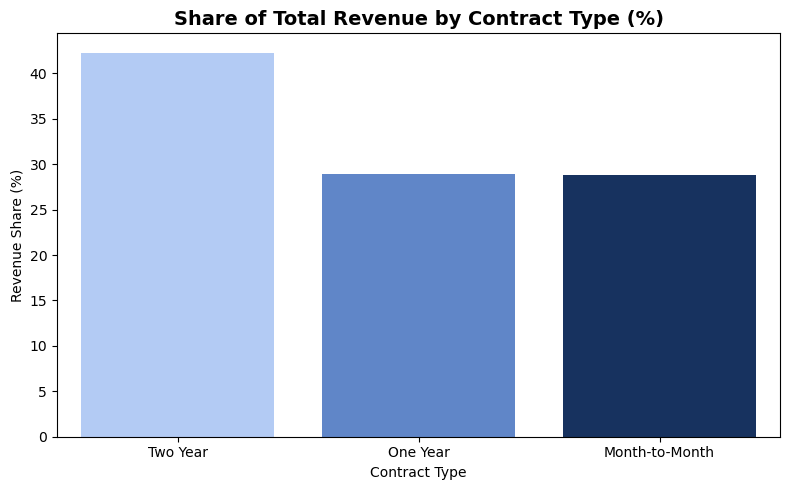

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
rev_by_contract = (
    df.groupby('contract')['total_revenue']
    .sum()
    .sort_values(ascending=False)
)

rev_share = (rev_by_contract / rev_by_contract.sum() * 100).round(2)

rev_df = rev_share.reset_index()
rev_df.columns = ['contract', 'share']

# Blue palette
colors = ["#a8c8ff", "#4f81d9", "#0b2f6b"]

plt.figure(figsize=(8,5))
sns.barplot(
    data=rev_df,
    x='contract',
    y='share',
    palette=colors
)

plt.title("Share of Total Revenue by Contract Type (%)", fontsize=14, weight="bold")
plt.xlabel("Contract Type")
plt.ylabel("Revenue Share (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [77]:
avg_total_rev = df.groupby('contract')['total_revenue'].mean().round(2)

print("Average TOTAL revenue per customer:")
print(avg_total_rev)


Average TOTAL revenue per customer:
contract
Month-to-Month    1707.06
One Year          3981.80
Two Year          4799.18
Name: total_revenue, dtype: float64


/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_3699/3511650150.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


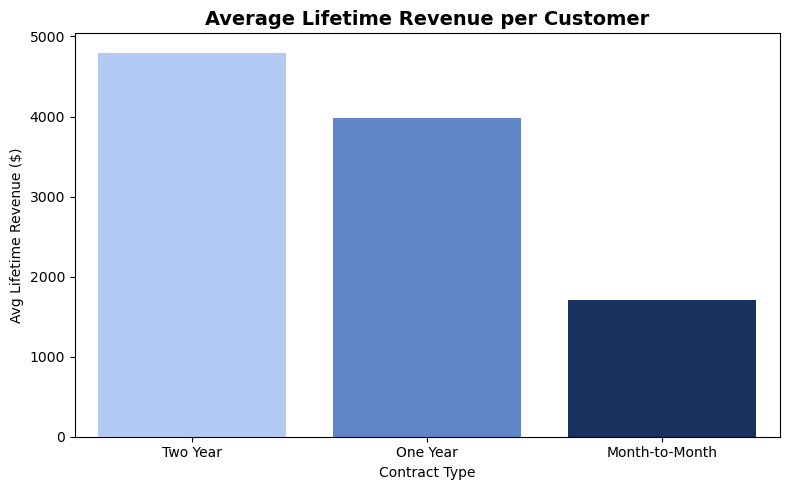

In [78]:
# Compute average lifetime revenue
avg_total_rev = (
    df.groupby('contract')['total_revenue']
    .mean()
    .round(2)
    .sort_values(ascending=False)
)

avg_df = avg_total_rev.reset_index()
avg_df.columns = ['contract', 'avg_lifetime_rev']

plt.figure(figsize=(8,5))
sns.barplot(
    data=avg_df,
    x='contract',
    y='avg_lifetime_rev',
    palette=colors
)

plt.title("Average Lifetime Revenue per Customer", fontsize=14, weight="bold")
plt.xlabel("Contract Type")
plt.ylabel("Avg Lifetime Revenue ($)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [79]:
# Filter for month-to-month customers
mtm = df[df['contract'] == 'Month-to-Month']

# Count churned and non-churned
churn_counts = mtm['churn'].value_counts()

non_churn = churn_counts.get(0, 0)
churn = churn_counts.get(1, 0)
total = non_churn + churn

# Percentages
non_churn_pct = non_churn / total * 100
churn_pct = churn / total * 100

print(f"Month-to-Month customers total: {total}")
print(f"Non-Churned: {non_churn} ({non_churn_pct:.2f}%)")
print(f"Churned:     {churn} ({churn_pct:.2f}%)")


Month-to-Month customers total: 3610
Non-Churned: 1955 (54.16%)
Churned:     1655 (45.84%)


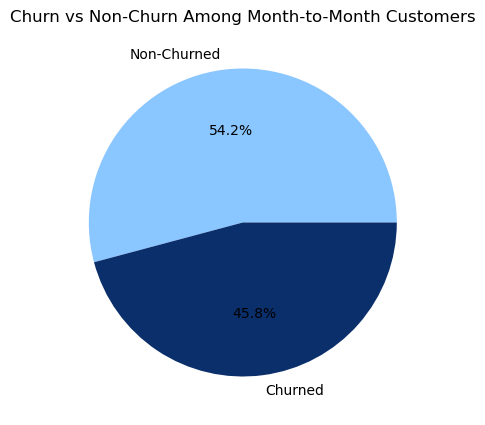

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.pie(
    [non_churn, churn],
    labels=["Non-Churned", "Churned"],
    autopct="%.1f%%",
    colors=["#8ac6ff", "#0b2f6b"]
)
plt.title("Churn vs Non-Churn Among Month-to-Month Customers")
plt.show()


In [81]:
# Avoid division by zero
df['avg_monthly_rev'] = df['total_revenue'] / df['tenure_in_months'].replace(0, 1)

avg_monthly_rev = df.groupby('contract')['avg_monthly_rev'].mean().round(2)

print("Average MONTHLY revenue per customer:")
print(avg_monthly_rev)


Average MONTHLY revenue per customer:
contract
Month-to-Month    89.04
One Year          89.61
Two Year          85.12
Name: avg_monthly_rev, dtype: float64


/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_3699/2218051343.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


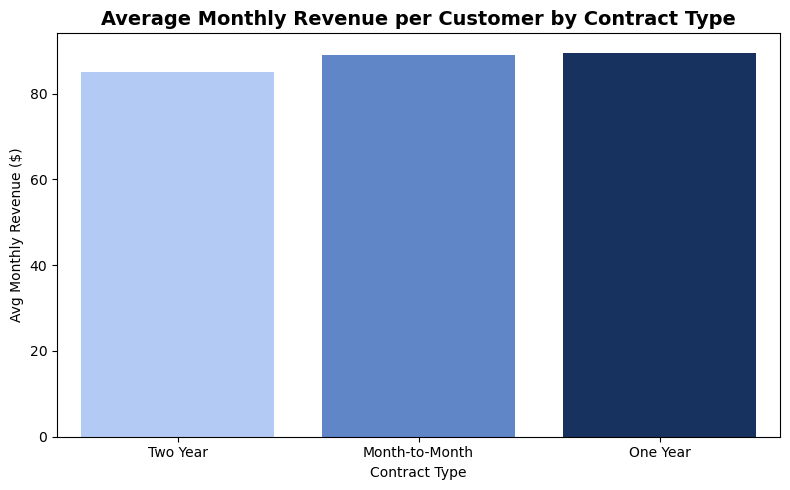

In [82]:
# Create monthly revenue
df["avg_monthly_rev"] = df["total_revenue"] / df["tenure_in_months"].replace(0,1)

# Compute average monthly revenue
avg_monthly_rev = df.groupby("contract")["avg_monthly_rev"].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(
    x=avg_monthly_rev.index,
    y=avg_monthly_rev.values,
    palette=colors
)

plt.title("Average Monthly Revenue per Customer by Contract Type", fontsize=14, weight='bold')
plt.ylabel("Avg Monthly Revenue ($)")
plt.xlabel("Contract Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [83]:
# Filter Month-to-Month customers only
mtm = df[df["contract"] == "Month-to-Month"]

# Group by churn status
avg_monthly_rev = (
    mtm.groupby("churn")["monthly_charge"]
    .mean()
    .rename({0: "Non-Churned", 1: "Churned"})
)

avg_monthly_rev


churn
Non-Churned    59.293632
Churned        73.019396
Name: monthly_charge, dtype: float64

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_3699/645947808.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


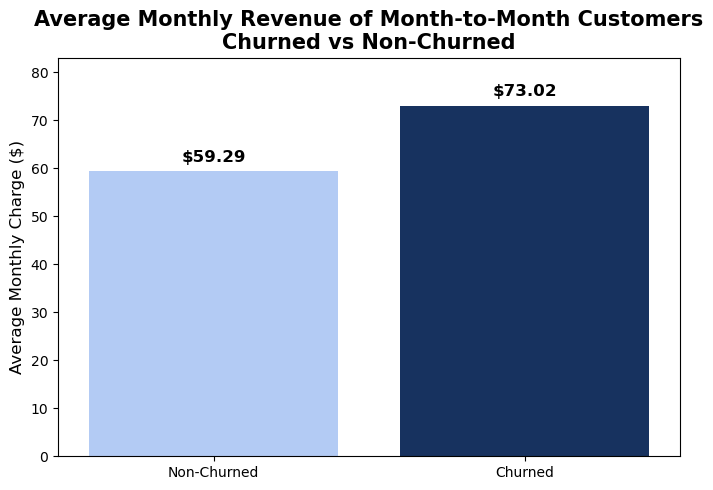

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colors: light blue (non-churned) → dark blue (churned)
colors = ["#a8c8ff", "#0b2f6b"]

plt.figure(figsize=(7,5))

sns.barplot(
    x=avg_monthly_rev.index,
    y=avg_monthly_rev.values,
    palette=colors
)

plt.title("Average Monthly Revenue of Month-to-Month Customers\nChurned vs Non-Churned",
          fontsize=15, weight="bold")

plt.xlabel("")
plt.ylabel("Average Monthly Charge ($)", fontsize=12)

# Increase y-axis limit so labels don't touch top
max_val = avg_monthly_rev.values.max()
plt.ylim(0, max_val + 10)   # <-- added padding above the tallest bar

# Add numbers on top of bars (higher vertical offset)
for i, v in enumerate(avg_monthly_rev.values):
    plt.text(i, v + 2, f"${v:.2f}", 
             ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


In [85]:
# Filter month-to-month customers
mtm = df[df["contract"] == "Month-to-Month"].copy()

# Total number of MTM customers
total_mtm = len(mtm)

# Convert churn values to readable labels
mtm["churn_label2"] = mtm["churn"].map({1: "Churned", 0: "Non-Churned"})

# List of service columns
service_cols = [
    "internet_service", "phone_service", "unlimited_data", "multiple_lines",
    "streaming_tv", "streaming_movies", "streaming_music",
    "device_protection_plan", "online_backup", "online_security",
    "premium_tech_support"
]

# Calculate percentages
service_percent = {}

for col in service_cols:
    users = mtm[mtm[col] == "Yes"]
    pct = (
        users.groupby("churn_label2").size() / total_mtm * 100
    ).reindex(["Non-Churned", "Churned"], fill_value=0)
    service_percent[col] = pct

service_percent = pd.DataFrame(service_percent).T
service_percent.index.name = "Service"

service_percent


churn_label2,Non-Churned,Churned
Service,,
internet_service,42.548476,43.102493
phone_service,48.642659,41.606648
unlimited_data,36.343490,36.925208
multiple_lines,17.313019,20.000000
streaming_tv,14.681440,18.199446
streaming_movies,14.626039,18.171745
streaming_music,14.958449,16.204986
device_protection_plan,12.409972,11.551247
online_backup,15.401662,11.218837


<Figure size 1200x700 with 0 Axes>

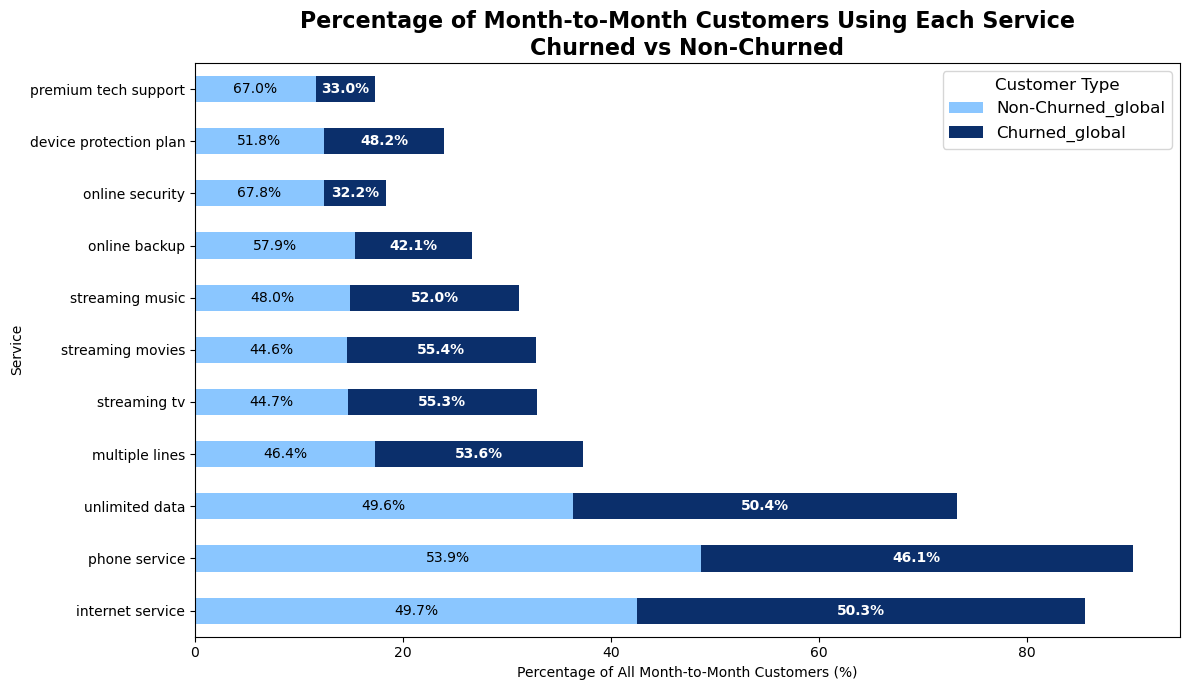

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

services_cols = [
    'internet_service', 'phone_service', 'unlimited_data', 'multiple_lines',
    'streaming_tv', 'streaming_movies', 'streaming_music', 'online_backup',
    'online_security', 'device_protection_plan', 'premium_tech_support'
]

# Filter to Month-to-Month customers only
mtm = df[df['contract'] == 'Month-to-Month'].copy()
n_mtm = len(mtm)

rows = []
for srv in services_cols:
    # Customers who have this service
    subset = mtm[mtm[srv] == 'Yes']
    total_srv = len(subset)

    if total_srv == 0:
        continue

    non_cnt = (subset['churn'] == 0).sum()
    ch_cnt  = (subset['churn'] == 1).sum()

    # 1) GLOBAL percentages (for bar lengths – same as before)
    non_global = non_cnt / n_mtm * 100
    ch_global  = ch_cnt  / n_mtm * 100

    # 2) WITHIN-SERVICE percentages (for labels – sum to 100%)
    non_within = non_cnt / total_srv * 100
    ch_within  = ch_cnt  / total_srv * 100

    rows.append({
        "service": srv.replace('_', ' '),
        "Non-Churned_global": non_global,
        "Churned_global": ch_global,
        "Non-Churned_within": non_within,
        "Churned_within": ch_within
    })

plot_df = pd.DataFrame(rows).set_index("service")

# ---- Plot (same axes as your previous chart) ----
plt.figure(figsize=(12, 7))
colors = ["#8ac6ff", "#0b2f6b"]  # light blue, dark blue

ax = plot_df[["Non-Churned_global", "Churned_global"]].plot(
    kind="barh",
    stacked=True,
    color=colors,
    edgecolor="none",
    figsize=(12, 7)
)

# Add WITHIN-service percentages as text inside bars
for i, svc in enumerate(plot_df.index):
    non_len   = plot_df.loc[svc, "Non-Churned_global"]
    ch_len    = plot_df.loc[svc, "Churned_global"]
    non_with  = plot_df.loc[svc, "Non-Churned_within"]
    ch_with   = plot_df.loc[svc, "Churned_within"]

    # Non-churn label (left segment)
    if non_len > 0:
        ax.text(
            non_len / 2, i,
            f"{non_with:.1f}%",
            ha="center", va="center",
            color="black", fontsize=10
        )

    # Churn label (right segment)
    if ch_len > 0:
        ax.text(
            non_len + ch_len / 2, i,
            f"{ch_with:.1f}%",
            ha="center", va="center",
            color="white", fontsize=10, fontweight="bold"
        )

# Cosmetics (same axes meaning as before)
plt.title(
    "Percentage of Month-to-Month Customers Using Each Service\n"
    "Churned vs Non-Churned",
    fontsize=16, weight="bold"
)
plt.xlabel("Percentage of All Month-to-Month Customers (%)")
plt.ylabel("Service")

plt.legend(
    title="Customer Type",
    fontsize=12,
    title_fontsize=12,
    loc="upper right",
    facecolor="white"
)

plt.tight_layout()
plt.show()


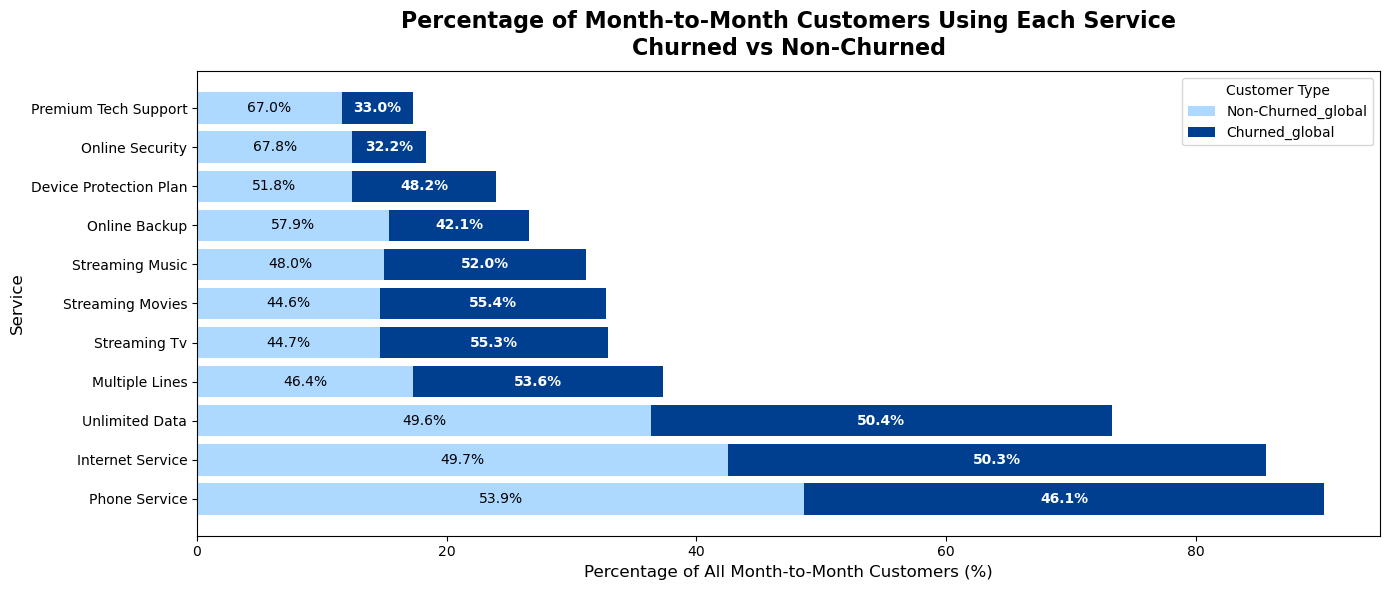

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filter to Month-to-Month customers
m2m = df[df['contract'] == 'Month-to-Month'].copy()
n_m2m = len(m2m)

# 2. Detect which column is the churn flag
if 'churn' in m2m.columns:
    churn_col = 'churn'
elif 'churn_value' in m2m.columns:
    churn_col = 'churn_value'
else:
    raise ValueError("No churn column found (expected 'churn' or 'churn_value').")

# Normalize churn to a boolean Series: True = churned
ch_raw = m2m[churn_col]

if ch_raw.dtype == 'O':
    # text labels
    churn_flag = ch_raw.astype(str).str.lower().isin(
        ["yes", "churned", "1", "true", "terminated"]
    )
else:
    # numeric 0/1 or similar
    churn_flag = ch_raw.astype(int) == 1

m2m['__churn_flag__'] = churn_flag

# 3. Service columns (adjust if your names differ)
service_cols = [
    'internet_service', 'phone_service', 'unlimited_data', 'multiple_lines',
    'streaming_tv', 'streaming_movies', 'streaming_music', 'online_backup',
    'online_security', 'device_protection_plan', 'premium_tech_support'
]

rows = []

for svc in service_cols:
    if svc not in m2m.columns:
        continue  # skip if column missing

    # customers using this service
    subset = m2m[m2m[svc] == 'Yes']
    total_users = len(subset)
    if total_users == 0:
        continue

    # percentage of ALL M2M customers who use this service
    global_pct = total_users / n_m2m * 100

    # churn stats within this service
    churned_cnt = subset['__churn_flag__'].sum()
    churn_within = churned_cnt / total_users * 100
    non_within = 100 - churn_within

    # convert within-service % into global stacked-bar widths
    non_global = global_pct * non_within / 100
    churn_global = global_pct * churn_within / 100

    # nice label
    pretty_name = svc.replace('_', ' ').title()

    rows.append({
        'service': pretty_name,
        'Non_churned_global': non_global,
        'Churned_global': churn_global,
        'non_within': non_within,
        'churn_within': churn_within,
        'global_pct': global_pct
    })

# 4. Build DataFrame & sort by global usage (high -> low)
plot_df = pd.DataFrame(rows)

# If you want high usage at the BOTTOM (as in your example),
# sort ascending (small at top, big at bottom)
plot_df = plot_df.sort_values('global_pct', ascending=False).set_index('service')

# 5. Plot
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#ADD8FF', '#003F8F']  # light blue, dark blue

ax.barh(
    plot_df.index,
    plot_df['Non_churned_global'],
    color=colors[0],
    label='Non-Churned_global'
)
ax.barh(
    plot_df.index,
    plot_df['Churned_global'],
    left=plot_df['Non_churned_global'],
    color=colors[1],
    label='Churned_global'
)

# 6. Text labels inside bars (within-service %)
for i, (svc, row) in enumerate(plot_df.iterrows()):
    # center of each segment on x-axis
    non_center = row['Non_churned_global'] / 2
    churn_center = row['Non_churned_global'] + row['Churned_global'] / 2

    # non-churned label: black
    ax.text(
        non_center, i,
        f"{row['non_within']:.1f}%",
        ha='center', va='center',
        color='black', fontsize=10
    )

    # churned label: white + bold
    ax.text(
        churn_center, i,
        f"{row['churn_within']:.1f}%",
        ha='center', va='center',
        color='white', fontsize=10, fontweight='bold'
    )

# 7. Titles, labels, legend
ax.set_title(
    "Percentage of Month-to-Month Customers Using Each Service\n"
    "Churned vs Non-Churned",
    fontsize=16, fontweight='bold', pad=12
)
ax.set_xlabel("Percentage of All Month-to-Month Customers (%)", fontsize=12)
ax.set_ylabel("Service", fontsize=12)

ax.legend(
    title='Customer Type',
    loc='upper right',
    fontsize=10,
    title_fontsize=10
)

plt.tight_layout()
plt.show()




/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_3699/4121005978.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


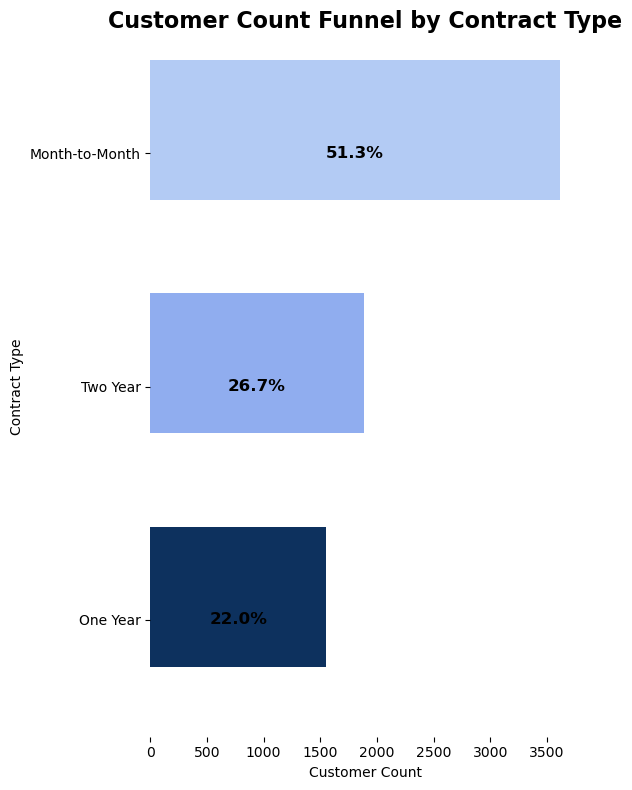

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
contract_counts = df["contract"].value_counts()
total_customers = contract_counts.sum()

# Create dataframe with percentages
funnel_df = (
    contract_counts.sort_values(ascending=False)
    .to_frame(name="count")
)
funnel_df["percentage"] = (funnel_df["count"] / total_customers * 100).round(1)

# Color palette
colors = ["#a8c8ff", "#80a7ff", "#002f6b"]

plt.figure(figsize=(6, 8))

# Horizontal bars for funnel
sns.barplot(
    x=funnel_df["count"],
    y=funnel_df.index,
    palette=colors
)

plt.title("Customer Count Funnel by Contract Type", fontsize=16, weight="bold")
plt.xlabel("Customer Count")
plt.ylabel("Contract Type")

# Remove grid
sns.despine(left=True, bottom=True)

# Adjust bar height to look more like a funnel
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    bar.set_height(0.6)

# Add percentage labels inside bars
for i, (count, pct) in enumerate(zip(funnel_df["count"], funnel_df["percentage"])):
    plt.text(
        count * 0.5,             # halfway inside the bar
        i,                       # bar position
        f"{pct}%",               # label
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        weight="bold"
    )

plt.tight_layout()
plt.show()
